In [141]:
# imposto la directory di lavoro
import os
os.chdir('C:/Users/dibid/OneDrive/Desktop/fingerprint-recognition-main/data')

In [142]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [143]:
# estraggo i nomi dei file e le relative etichette nel formato: ['1 (1)', '1']
def data_info(direct):
  files = [file.strip() for file in os.listdir('./'+direct)] 
  filenames = []     
  for file in files:            
    add = [file[:-4],file[0]]
    filenames.append(add)
  return filenames

In [144]:
# creo un dataframe contenente i filenames e le etichette per l'addestramento e la fase di test
df_test = data_info(direct = 'test')
df_train = data_info(direct = 'train')
train = pd.DataFrame(df_train, columns =['filename', 'label']) 
test = pd.DataFrame(df_test, columns = ['filename', 'label'])
display(train.head(), test.head())

,filename,label
0,1 (1),1
1,1 (10),1
2,1 (2),1
3,1 (3),1
4,1 (4),1


,filename,label
0,1,1
1,10,1
2,11,1
3,12,1
4,13,1


In [145]:
# dimensioni delle immagini
dimx = 144
dimy = 144

In [146]:
# Restituisce un dataframe contenente le informazioni dei pixel di ogni immagine
def pixel_info(direct, df):
  pixels = []

  for file in list(df['filename']):
    from PIL import Image
    im = Image.open('./'+direct+'/'+file+'.bmp')
    pix = list(im.getdata())   # estraggo i valori di ogni punto dell'immagine
    pixels.append(pix)

  df_pix = pd.DataFrame(pixels, columns = list(range(dimx*dimy))) 
  return df_pix

In [147]:
train_pix = pixel_info('train', train)
test_pix = pixel_info('test', test)

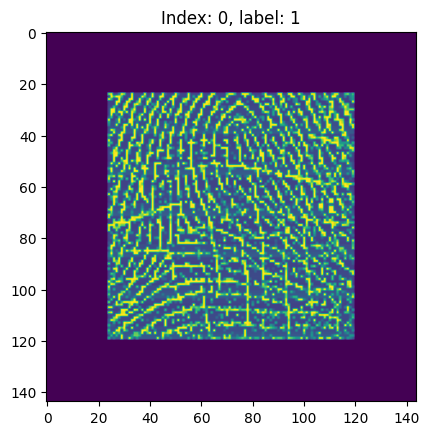

In [148]:
# visualizzo un esempio di immagine per verificare sia tutto ok
idx = 0
img = train_pix.loc[idx, '0':].values.reshape(144, 144).astype(int)
label = train.loc[idx, 'label']

plt.title('Index: %i, label: %s'%(idx, label))
plt.imshow(img)
plt.show()

Train-Test-Split

In [149]:
# recupero il numero di etichette
num_labels = train['label'].nunique()
print(f'Numero di etichette: {num_labels}')

Numero di etichette: 8


In [150]:
# divido i dati in dati di train e validation (30% del totale) per monitorare le performance
X_train, X_val, y_train, y_val = train_test_split(train_pix.values, train['label'], test_size = 0.3, random_state=42, shuffle=True, stratify=None)

# resize and normalizzazione
X_train = X_train.reshape(-1, dimx, dimy, 1)
X_train = X_train/255

X_val = X_val.reshape(-1, dimx, dimy, 1)
X_val = X_val/255

X_test = test_pix.values.reshape(-1, dimx, dimy, 1)
X_test = X_test/255

# train/test label one-hot-encoding
y_train_vec = np.zeros((len(y_train), num_labels))
for i, digit in enumerate(y_train):
    y_train_vec[int(i), int(digit)-1] = 1

y_val_vec = np.zeros((len(y_val), num_labels))
for i, digit in enumerate(y_val):
    y_val_vec[int(i), int(digit)-1] = 1

CNN Model

In [151]:
# creazione del modello
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

nb_classes = num_labels
# filtri convoluzionali da usare
nb_filters = 32
# dimensione del pooling
pool_size = (2, 2)
# dimensione dei filtri convoluzionali
kernel_size = (3, 3)


model = Sequential([
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], padding='valid', input_shape=X_train.shape[1:], activation = 'relu'), # primo strato di conv
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu'), # secondo strato di conv
                  MaxPooling2D(pool_size=pool_size),
                  Dropout(0.25), # overfitting reduction

                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dropout(0.5),
                  Dense(nb_classes, activation = 'softmax')
])

C:\Users\dibid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [152]:
# compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [153]:
# si impostano i parametri per il training
batch = 16 #8
epoch = 10
es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./model/model_cnn.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0625 - loss: 2.1122
Epoch 1: val_accuracy improved from -inf to 0.29167, saving model to ./model/model_cnn.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1054 - loss: 2.0743 - val_accuracy: 0.2917 - val_loss: 1.9799
Epoch 2/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1250 - loss: 2.0525
Epoch 2: val_accuracy did not improve from 0.29167
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2527 - loss: 1.9961 - val_accuracy: 0.2917 - val_loss: 1.9261
Epoch 3/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3125 - loss: 1.9432
Epoch 3: val_accuracy improved from 0.29167 to 0.62500, saving model to ./model/model_cnn.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4036 - loss: 1.8629 - val_accuracy: 0.6250 - val_loss: 1.8108
Epoch 4/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3125 - loss: 1.8730
Epoch 4: val_accuracy improved from 0.62500 to 0.79167, saving model to ./model/model_cn

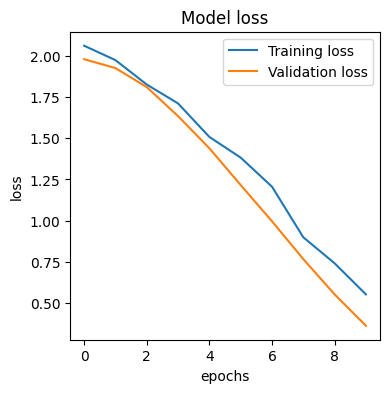

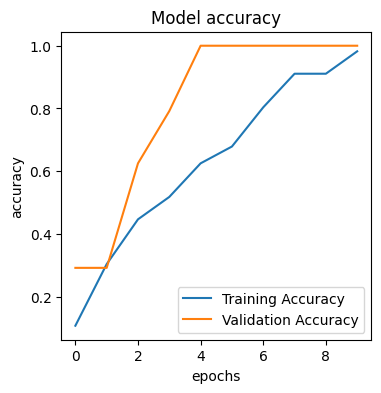

In [154]:
# addestramento del modello
history = model.fit(X_train, y_train_vec, epochs=epoch, callbacks=[es, mc], batch_size=batch, validation_data=(X_val, y_val_vec))

# visualization of loss and accuracy models
# visualizzazione di loss e accuracy del modello durante l'addestramento
plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [155]:
from tensorflow.keras.models import load_model

# caricamento del modello
best = load_model('./model/model_cnn.keras')

In [156]:
# valutazione del modello
val_predict = np.argmax(best.predict(X_val), axis=1)

print("\n Validation: %.4f" % (best.evaluate(X_val, y_val_vec)[1]))
print(classification_report(np.argmax(y_val_vec, axis=1),val_predict))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 1.0000 - loss: 1.4395

 Validation: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [157]:
# predizione del modello sul file di test
test_predict = np.argmax(best.predict(X_test), axis=1)

# mapping degli indici delle etichette da 0-7 a 1-8
true_class = [pred+1 for pred in test_predict] 

test['label'] = true_class

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [158]:
# salvataggio dei risultati
test['filename'] = pd.to_numeric(test["filename"])      # filename to numeric
test                                                    

result = test.sort_values(by=['filename'], ascending=True)
result.head()

result.to_csv('C:/Users/dibid/OneDrive/Desktop/fingerprint-recognition-main/result/result_provaAcaso_cnn.csv', index = False)

In [159]:
# open csv
result = pd.read_csv('C:/Users/dibid/OneDrive/Desktop/fingerprint-recognition-main/result/result_provaAcaso_cnn.csv')
result.head()

,filename,label
0,1,7
1,2,6
2,3,2
3,4,6
4,5,1


In [160]:
# mostra le occorrenze di ogni classe
from collections import Counter
Counter(result['label'])

Counter({8: 22, 6: 14, 3: 13, 2: 10, 5: 10, 7: 5, 1: 3, 4: 3})